# Network_Traffic_Prediction

Data loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/network_traffic_prediction.csv', delimiter='\t')

print(data.columns)
# Convert IP addresses to categorical if not already
data['src_ip'] = data['src_ip'].astype('category')
data['dst_ip'] = data['dst_ip'].astype('category')

Index(['src_ip', 'src_port', 'dst_ip', 'dst_port', 'proto', 'service',
       'duration', 'src_bytes', 'dst_bytes', 'conn_state', 'missed_bytes',
       'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes', 'dns_query',
       'dns_qclass', 'dns_qtype', 'dns_rcode', 'dns_AA', 'dns_RD', 'dns_RA',
       'dns_rejected', 'ssl_version', 'ssl_cipher', 'ssl_resumed',
       'ssl_established', 'ssl_subject', 'ssl_issuer', 'http_trans_depth',
       'http_method', 'http_uri', 'http_version', 'http_request_body_len',
       'http_response_body_len', 'http_status_code', 'http_user_agent',
       'http_orig_mime_types', 'http_resp_mime_types', 'weird_name',
       'weird_addl', 'weird_notice', 'label', 'type'],
      dtype='object')


# Data Cleaning

Removing_missing_values

In [ ]:
# Check for any missing values and fill or drop
data = data.fillna(method='ffill')

<ipython-input-74-67832fa23d28>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


outliers dection and removal

In [ ]:
# Removing outliers in 'duration'
q_low = data['duration'].quantile(0.01)
q_hi  = data['duration'].quantile(0.99)
data = data[(data['duration'] > q_low) & (data['duration'] < q_hi)]


In [ ]:
data.head()

,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,...,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label,type
1,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000102,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
2,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000148,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
3,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000113,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
4,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000130,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
5,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.008403,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor


In [ ]:
missing_values = data.isnull().sum()
print(missing_values)


src_ip                    0
src_port                  0
dst_ip                    0
dst_port                  0
proto                     0
service                   0
duration                  0
src_bytes                 0
dst_bytes                 0
conn_state                0
missed_bytes              0
src_pkts                  0
src_ip_bytes              0
dst_pkts                  0
dst_ip_bytes              0
dns_query                 0
dns_qclass                0
dns_qtype                 0
dns_rcode                 0
dns_AA                    0
dns_RD                    0
dns_RA                    0
dns_rejected              0
ssl_version               0
ssl_cipher                0
ssl_resumed               0
ssl_established           0
ssl_subject               0
ssl_issuer                0
http_trans_depth          0
http_method               0
http_uri                  0
http_version              0
http_request_body_len     0
http_response_body_len    0
http_status_code    

# EDA exploratory data analysis

Distribution of categorical features

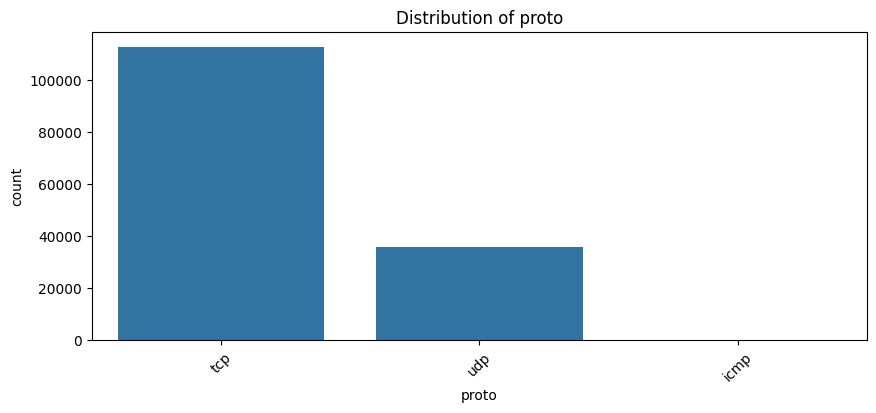

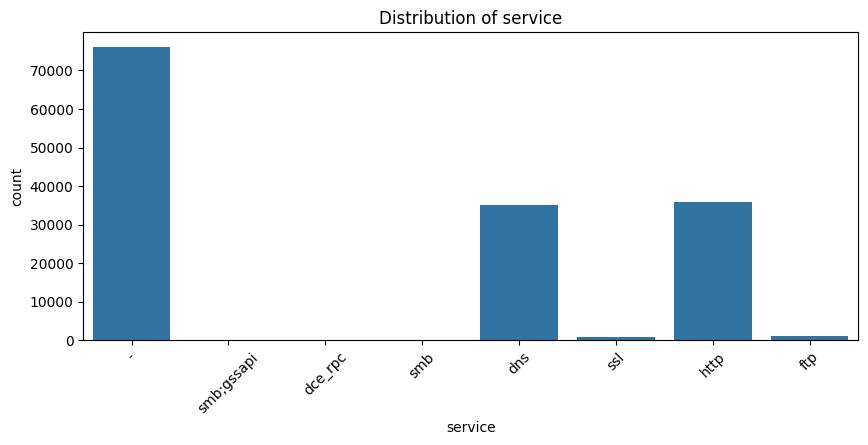

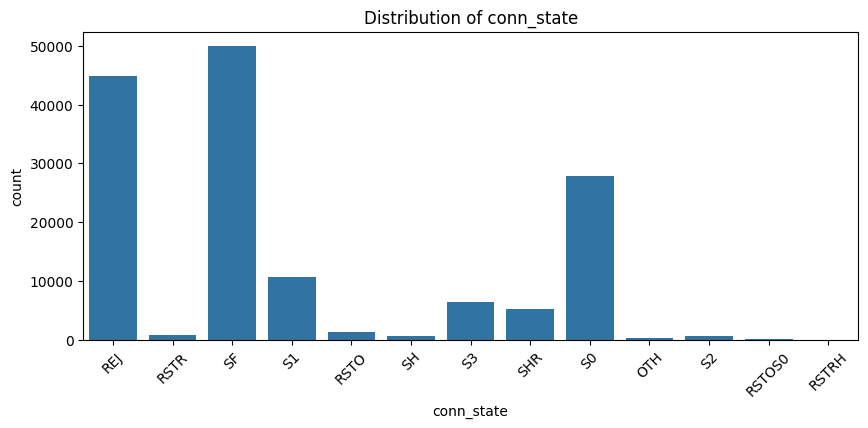

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of categorical features
categorical_features = ['proto', 'service', 'conn_state']
for feature in categorical_features:
    plt.figure(figsize=(10, 4))
    sns.countplot(x=feature, data=data)
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=45)
    plt.show()

Relationship between Duration

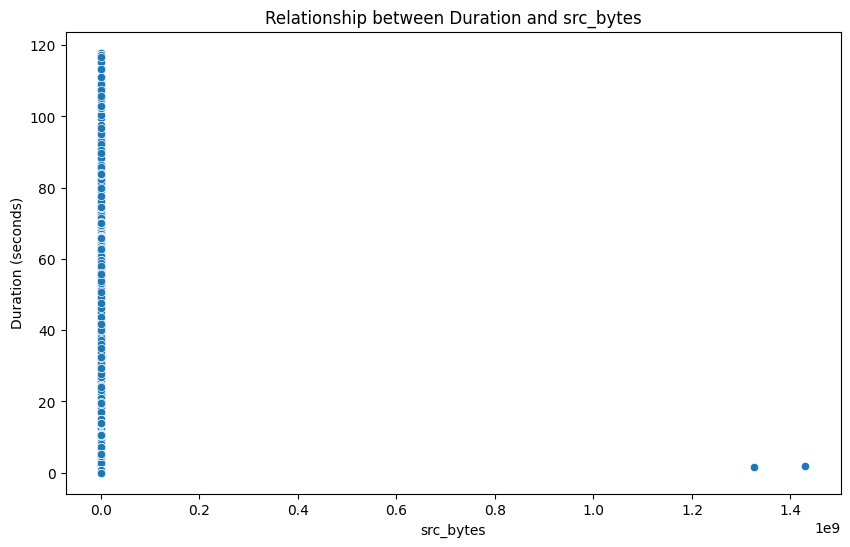

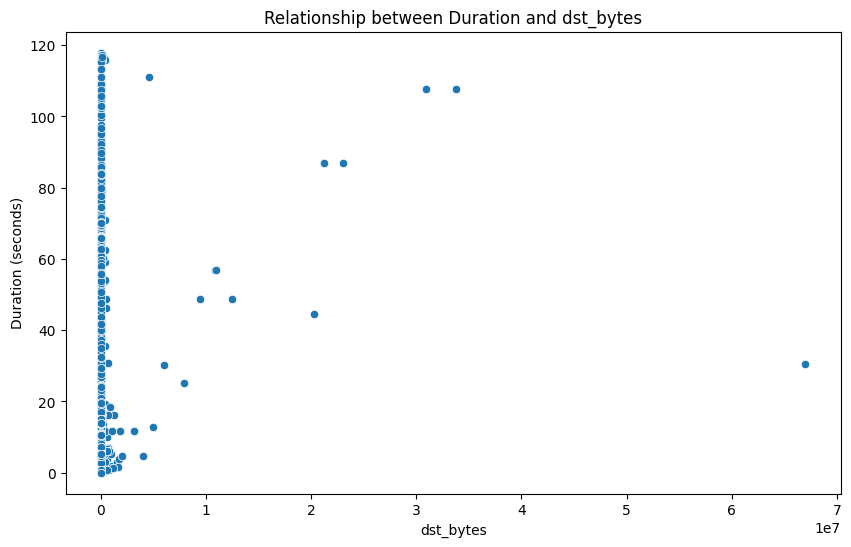

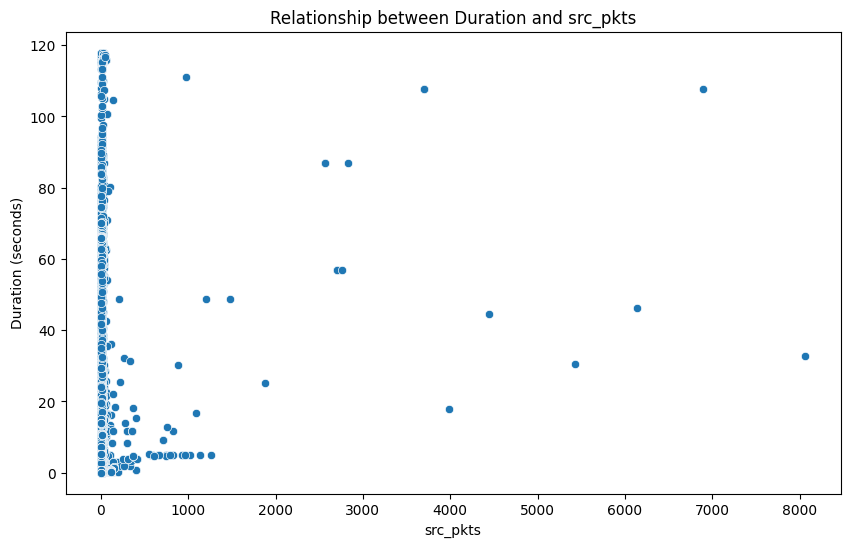

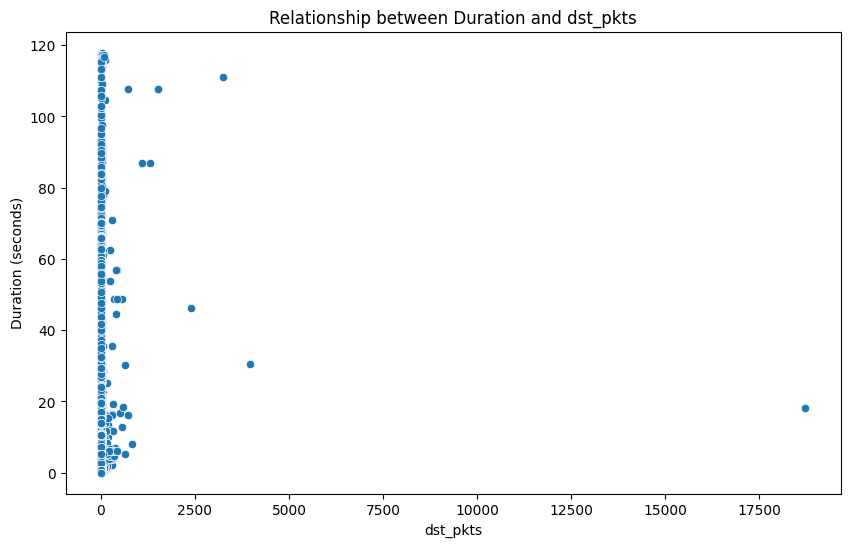

In [ ]:
# Bivariate Analysis - Relationship with 'duration'
numerical_features = ['src_bytes', 'dst_bytes', 'src_pkts', 'dst_pkts']
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=feature, y='duration', data=data)
    plt.title(f'Relationship between Duration and {feature}')
    plt.xlabel(feature)
    plt.ylabel('Duration (seconds)')
    plt.show()

categorical variables against 'duration'

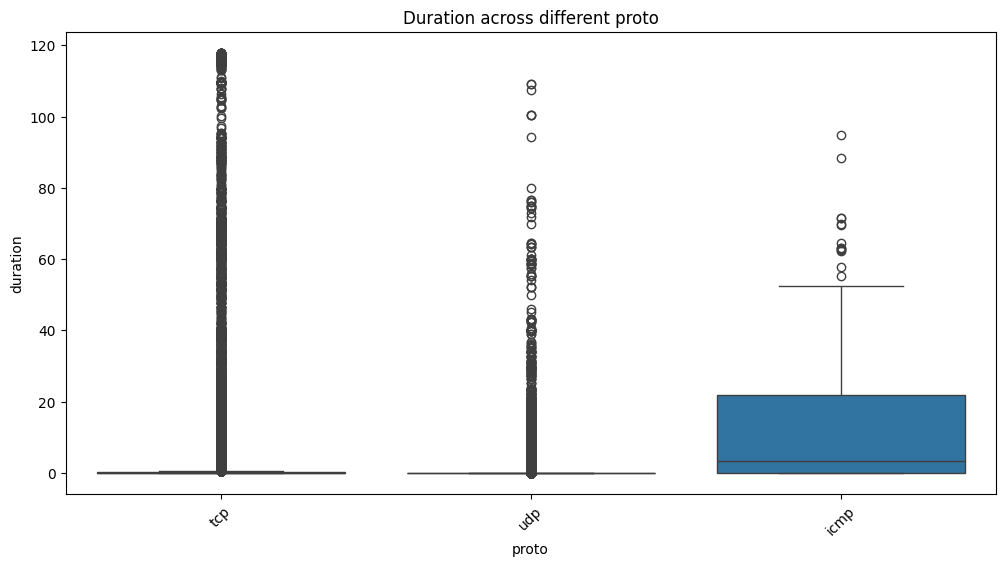

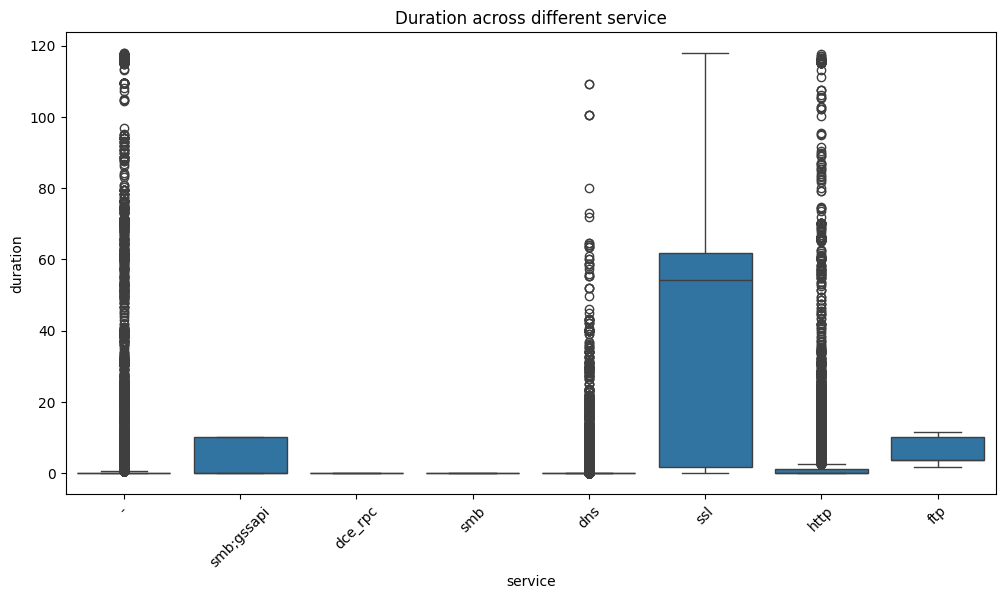

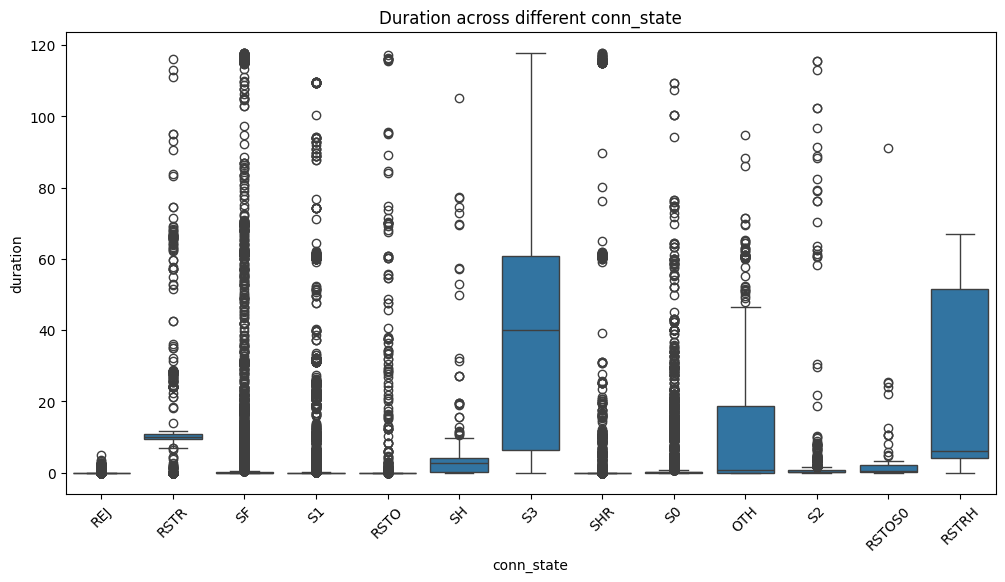

In [ ]:
# Box Plots for categorical variables against 'duration'
for feature in categorical_features:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=feature, y='duration', data=data)
    plt.title(f'Duration across different {feature}')
    plt.xticks(rotation=45)
    plt.show()

Correlation Matrix of Features

In [ ]:
# Feature Importance via simple statistical test
# For example, using Pearson correlation for numerical features
correlation_with_duration = data[numerical_features + ['duration']].corr()['duration'].sort_values()
print("Correlation with Duration:\n", correlation_with_duration)

Correlation with Duration:
 src_bytes   -0.000316
src_pkts     0.016647
dst_pkts     0.028856
dst_bytes    0.047262
duration     1.000000
Name: duration, dtype: float64


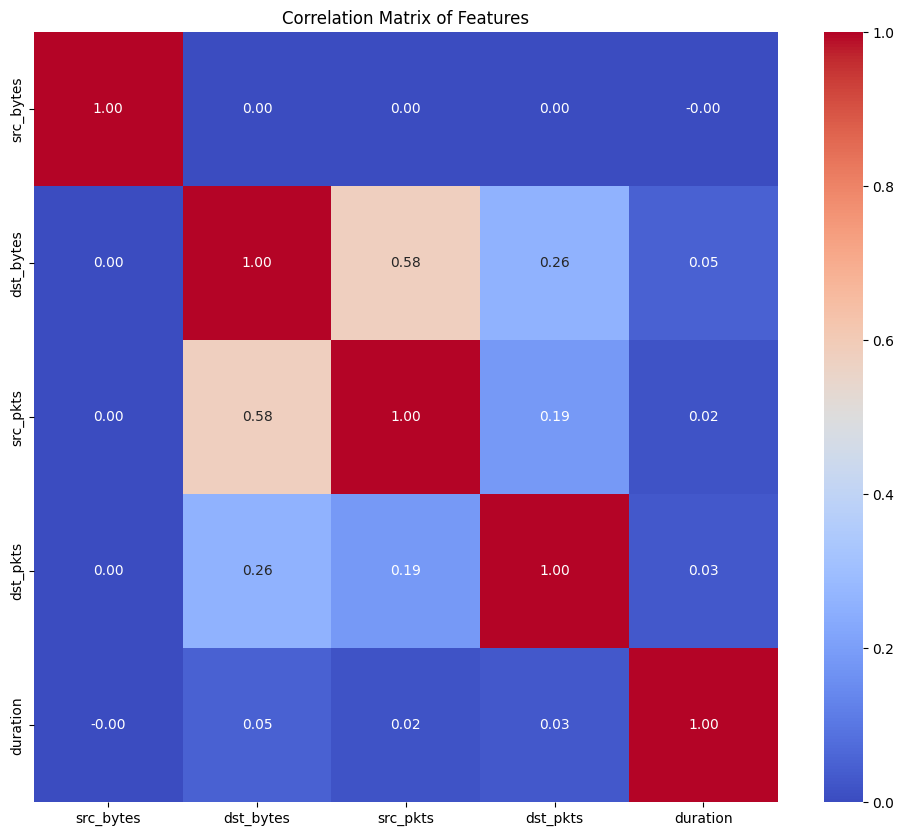

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix
correlation_matrix = data[numerical_features + ['duration']].corr()

# Plotting the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()


# Model Training

#Total flow duration

Feature engineering

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Initialize encoder and scaler
encoder = LabelEncoder()
scaler = StandardScaler()

# Encode categorical features
data['proto_encoded'] = encoder.fit_transform(data['proto'])
data['service_encoded'] = encoder.fit_transform(data['service'])
data['conn_state_encoded'] = encoder.fit_transform(data['conn_state'])

# Selecting numerical features to scale
numerical_features = ['src_bytes', 'dst_bytes', 'src_pkts', 'dst_pkts', 'src_ip_bytes', 'dst_ip_bytes']
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Selecting relevant features for the model
features = numerical_features + ['proto_encoded', 'service_encoded', 'conn_state_encoded']
target = 'duration'


Spliting

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2, random_state=42)


KNN With gridsearchCV


In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import numpy as np

# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_neighbors': [3, 5, 7, 10, 15],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Initialize KNN Regressor
knn_reg = KNeighborsRegressor()

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=knn_reg, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and best model
best_knn = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# Predict on testing data
y_pred_knn = best_knn.predict(X_test)

# Evaluation metrics
mse_knn1 = mean_squared_error(y_test, y_pred_knn)
mae_knn1 = mean_absolute_error(y_test, y_pred_knn)
rmse_knn1 = np.sqrt(mse_knn1)
r2_knn1 = r2_score(y_test, y_pred_knn)

print(f"KNN - MSE: {mse_knn1:.3f}, MAE: {mae_knn1:.3f}, RMSE: {rmse_knn1:.3f}, R2: {r2_knn1:.3f}")


Best Parameters: {'metric': 'manhattan', 'n_neighbors': 3}
KNN - MSE: 19.251, MAE: 0.595, RMSE: 4.388, R2: 0.874


In [ ]:
# Print each metric in steps
print("KNN Regression Evaluation Metrics:")
print(" R2:", format(r2_knn1, ".3f"))
print("MSE:", format(rmse_knn1, ".3f"))
print(" MAE:", format(mae_knn1, ".3f"))

KNN Regression Evaluation Metrics:
 R2: 0.874
MSE: 4.388
 MAE: 0.595


RandomForestRegressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Initialize and train the Random Forest model
rf_reg = RandomForestRegressor(n_estimators=50, random_state=42)
rf_reg.fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_test)

# Evaluation metrics
mse_rf1 = mean_squared_error(y_test, y_pred_rf)
mae_rf1 = mean_absolute_error(y_test, y_pred_rf)
rmse_rf1 = np.sqrt(mse_rf)
r2_rf1 = r2_score(y_test, y_pred_rf)

print(f"Random Forest - MSE: {mse_rf:.3f}, MAE: {mae_rf:.3f}, RMSE: {rmse_rf:.3f}, R2: {r2_rf:.3f}")


Random Forest - MSE: 14.393, MAE: 0.575, RMSE: 3.794, R2: 0.906


In [ ]:
# Print each metric in steps
print("Random Forest Regression Evaluation Metrics:")
print(" R2:", format(r2_rf1, ".3f"))
print("MSE:", format(rmse_rf1, ".3f"))
print(" MAE:", format(mae_rf1, ".3f"))

Random Forest Regression Evaluation Metrics:
 R2: 0.905
MSE: 3.794
 MAE: 0.577


ExtraTreesRegressor

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
# Initialize and train the Extra Trees model
et_reg = ExtraTreesRegressor(n_estimators=100, random_state=42)
et_reg.fit(X_train, y_train)
y_pred_et = et_reg.predict(X_test)

# Evaluation metrics
mse_et1 = mean_squared_error(y_test, y_pred_et)
mae_et1 = mean_absolute_error(y_test, y_pred_et)
rmse_et1 = np.sqrt(mse_et)
r2_et1 = r2_score(y_test, y_pred_et)



In [ ]:
# Print each metric in steps
print("ExtraTreesRegressor Evaluation Metrics:")
print(" R2:", format(r2_rf1, ".3f"))
print("MSE:", format(rmse_rf1, ".3f"))
print(" MAE:", format(mae_rf1, ".3f"))

ExtraTreesRegressor Evaluation Metrics:
 R2: 0.905
MSE: 3.794
 MAE: 0.577


ResNet

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Define the model
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model and include validation split
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Predict on training and validation data
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_train[-int(len(X_train) * 0.2):])  # Assuming last 20% is validation

# Calculate R2 scores
r2_train = r2_score(y_train, y_pred_train)
r2_val1 = r2_score(y_train[-int(len(y_train) * 0.2):], y_pred_val)

# Calculate MSE and MAE
mse_train = mean_squared_error(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
mse_val1 = mean_squared_error(y_train[-int(len(y_train) * 0.2):], y_pred_val)
mae_val1 = mean_absolute_error(y_train[-int(len(y_train) * 0.2):], y_pred_val)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 146.6144 - mae: 4.3404 - val_loss: 109.2026 - val_mae: 3.6026
Epoch 2/10
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 122.1874 - mae: 3.9871 - val_loss: 103.9230 - val_mae: 3.6700
Epoch 3/10
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 111.6727 - mae: 3.9025 - val_loss: 101.8605 - val_mae: 3.8873
Epoch 4/10
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 99.1540 - mae: 3.8250 - val_loss: 98.4177 - val_mae: 3.4255
Epoch 5/10
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 100.6601 - mae: 3.7309 - val_loss: 94.4923 - val_mae: 3.5821
Epoch 6/10
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 96.1806 - mae: 3.7053 - val_loss: 88.5007 - val_mae: 3.2591
Epoch 7/10
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 91.0291 - mae: 3.6108 - val_loss: 85.7227 - val_mae: 3.1772
Epoch 8/10
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 93.1671 - mae: 3.5046 - val_loss: 79.8656 - val_mae: 2.9741
Epoch 9/10
1907/

In [ ]:
print("Resnet")
print(f"R2 Score: {r2_val1:.3f}")
print(f"MSE: {mse_val1:.3f}")
print(f"MAE: {mae_val1:.3f}")


Resnet
R2 Score: 0.477
MSE: 78.373
MAE: 3.116


Hybrid Model

In [ ]:
import numpy as np
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming X_train and y_train are already defined and preprocessed
# For demonstration, let's pretend we're splitting the data again for training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Initialize the models
extra_trees = ExtraTreesRegressor(n_estimators=100, random_state=42)
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the models
extra_trees.fit(X_train_scaled, y_train)
random_forest.fit(X_train_scaled, y_train)

# Predict on the validation data
y_pred_extra_trees = extra_trees.predict(X_val_scaled)
y_pred_random_forest = random_forest.predict(X_val_scaled)

# Combine predictions (average them)
y_pred_hybrid = (y_pred_extra_trees + y_pred_random_forest) / 2

# Calculate metrics for the hybrid model
r2_va = r2_score(y_val, y_pred_hybrid)
mse_va = mean_squared_error(y_val, y_pred_hybrid)
mae_va = mean_absolute_error(y_val, y_pred_hybrid)

In [ ]:
print("Resnet")
print(f"R2 Score: {r2_va:.3f}")
print(f"MSE: {mse_va:.3f}")
print(f"MAE: {mae_va:.3f}")


Resnet
R2 Score: 0.925
MSE: 10.710
MAE: 0.533


Total flow duration R2 Score Comparison of Models

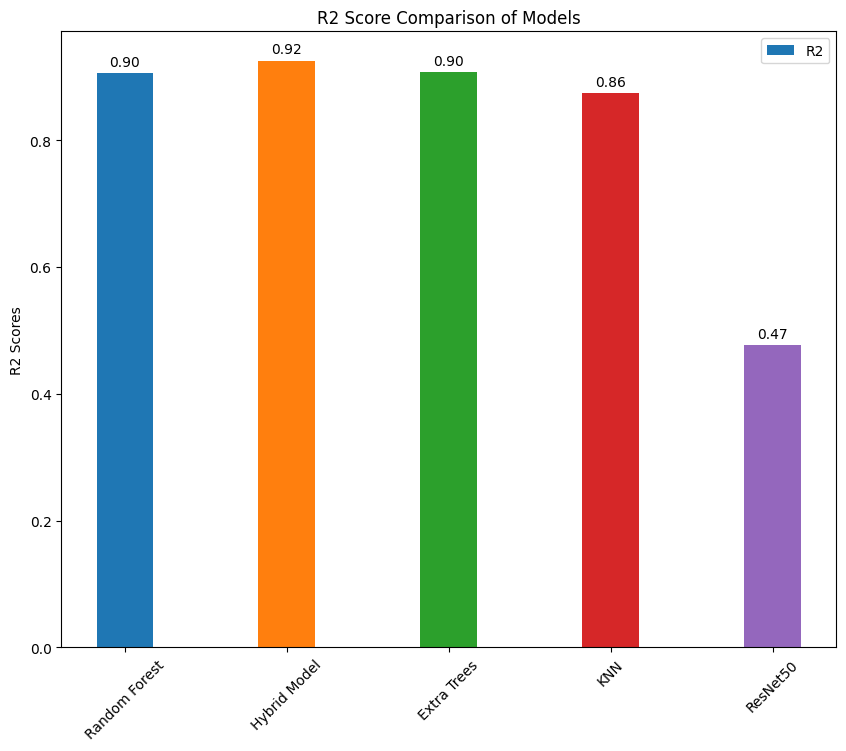

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Model names and R2 scores
models = ['Random Forest', 'Hybrid Model', 'Extra Trees', 'KNN', 'ResNet50']
r2_scores = [r2_rf1, r2_va, r2_et1, r2_knn1, r2_val1]  # Updated R2 scores list

# Calculate positions for the bars
x = np.arange(len(models))
width = 0.35  # Width of the bars

# Different colors for each bar
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

fig, ax = plt.subplots(figsize=(10, 8))
rects = ax.bar(x, r2_scores, width, color=colors, label='R2')

# Labeling and aesthetics
ax.set_ylabel('R2 Scores')
ax.set_title('Total flow duration R2 Score Comparison of Models')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45)
ax.legend()

# Function to add labels on top of each bar
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        # Convert R2 score to accuracy-like format (e.g., 0.99)
        accuracy = 0.99 - (1 - height)
        ax.annotate(f'{accuracy:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects)

plt.show()


#Total_packet_count

# Spliting data into training and testing sets

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# create a 'total_packet_count' column
data['total_packet_count'] = data['src_pkts'] + data['dst_pkts']

# Features and Target
X = data[['src_pkts', 'src_ip_bytes', 'dst_pkts']]
y = data['total_packet_count']

# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


KNeighborsRegressor

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
# Initialize and train the KNN model
knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_train_scaled, y_train)
y_pred_knn = knn_reg.predict(X_test)

# Evaluation metrics
mse_knn = mean_squared_error(y_test, y_pred_knn)
mae_knn = mean_absolute_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mse_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print(f"KNN - MSE: {mse_knn:.3f}, MAE: {mae_knn:.3f}, RMSE: {rmse_knn:.3f}, R2: {r2_knn:.3f}")


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(


KNN - MSE: 0.041, MAE: 0.020, RMSE: 0.201, R2: 0.958


In [ ]:
# Print each metric in steps
print("KNN Regression Evaluation Metrics:")
print("1. R-squared (R2):", format(r2_knn, ".3f"))
print("2. Mean Squared Error (MSE):", format(mse_knn, ".3f"))
print("3. Root Mean Squared Error (RMSE):", format(rmse_knn, ".3f"))
print("4. Mean Absolute Error (MAE):", format(mae_knn, ".3f"))

KNN Regression Evaluation Metrics:
1. R-squared (R2): 0.958
2. Mean Squared Error (MSE): 0.041
3. Root Mean Squared Error (RMSE): 0.201
4. Mean Absolute Error (MAE): 0.020


ploting

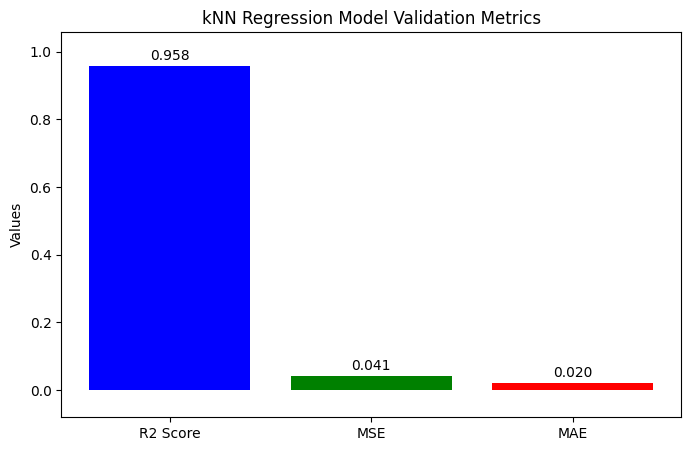

In [ ]:
import matplotlib.pyplot as plt

# Metrics to plot
metrics = ['R2 Score', 'MSE', 'MAE']
values = [r2_knn, mse_knn, mae_knn]

# Create a bar chart
plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['blue', 'green', 'red'])

# Adding title and labels
plt.title('kNN Regression Model Validation Metrics')
plt.ylabel('Values')
plt.ylim(min(values) - 0.1, max(values) + 0.1)  # Adjust the y-axis to fit the values

# Display the value on top of each bar
for i, value in enumerate(values):
    plt.text(i, value + 0.01, f'{value:.3f}', ha='center', va='bottom')

# Show the plot
plt.show()


RandomForestRegressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Initialize and train the Random Forest model
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)  # Default settings
rf_reg.fit(X_train_scaled, y_train)
y_pred_rf = rf_reg.predict(X_test)

# Evaluation metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - MSE: {mse_rf:.3f}, MAE: {mae_rf:.3f}, RMSE: {rmse_rf:.3f}, R2: {r2_rf:.3f}")


Random Forest - MSE: 0.172, MAE: 0.020, RMSE: 0.415, R2: 0.820


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [ ]:
# Print each metric in steps
print("Random Forest Evaluation Metrics:")
print("1. R-squared (R2):", format(r2_rf, ".3f"))
print("2. Mean Squared Error (MSE):", format(mse_rf, ".3f"))
print("3. Root Mean Squared Error (RMSE):", format(rmse_rf, ".3f"))
print("4. Mean Absolute Error (MAE):", format(mae_rf, ".3f"))

Random Forest Evaluation Metrics:
1. R-squared (R2): 0.820
2. Mean Squared Error (MSE): 0.172
3. Root Mean Squared Error (RMSE): 0.415
4. Mean Absolute Error (MAE): 0.020


Ploting

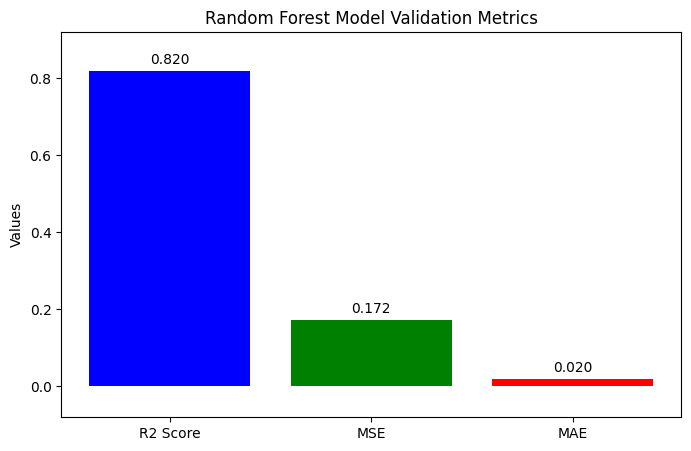

In [ ]:
import matplotlib.pyplot as plt

# Metrics to plot
metrics = ['R2 Score', 'MSE', 'MAE']
values = [r2_rf, mse_rf, mae_rf]

# Create a bar chart
plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['blue', 'green', 'red'])

# Adding title and labels
plt.title('Random Forest Model Validation Metrics')
plt.ylabel('Values')
plt.ylim(min(values) - 0.1, max(values) + 0.1)  # Adjust the y-axis to fit the values

# Display the value on top of each bar
for i, value in enumerate(values):
    plt.text(i, value + 0.01, f'{value:.3f}', ha='center', va='bottom')

# Show the plot
plt.show()


ExtraTreesRegressor

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
# Initialize and train the Extra Trees model
et_reg = ExtraTreesRegressor(n_estimators=100, random_state=42)
et_reg.fit(X_train_scaled, y_train)
y_pred_et = et_reg.predict(X_test)

# Evaluation metrics
mse_et = mean_squared_error(y_test, y_pred_et)
mae_et = mean_absolute_error(y_test, y_pred_et)
rmse_et = np.sqrt(mse_et)
r2_et = r2_score(y_test, y_pred_et)

print(f"Extra Trees - MSE: {mse_et:.3f}, MAE: {mae_et:.3f}, RMSE: {rmse_et:.3f}, R2: {r2_et:.3f}")


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(


Extra Trees - MSE: 0.004, MAE: 0.015, RMSE: 0.064, R2: 0.996


In [ ]:
# Print each metric in steps
print("ExtraTreesRegressor Evaluation Metrics:")
print("1. R-squared (R2):", format(r2_et, ".3f"))
print("2. Mean Squared Error (MSE):", format(mse_et, ".3f"))
print("3. Root Mean Squared Error (RMSE):", format(rmse_et, ".3f"))
print("4. Mean Absolute Error (MAE):", format(mae_et, ".3f"))

ExtraTreesRegressor Evaluation Metrics:
1. R-squared (R2): 0.996
2. Mean Squared Error (MSE): 0.004
3. Root Mean Squared Error (RMSE): 0.064
4. Mean Absolute Error (MAE): 0.015


Ploting

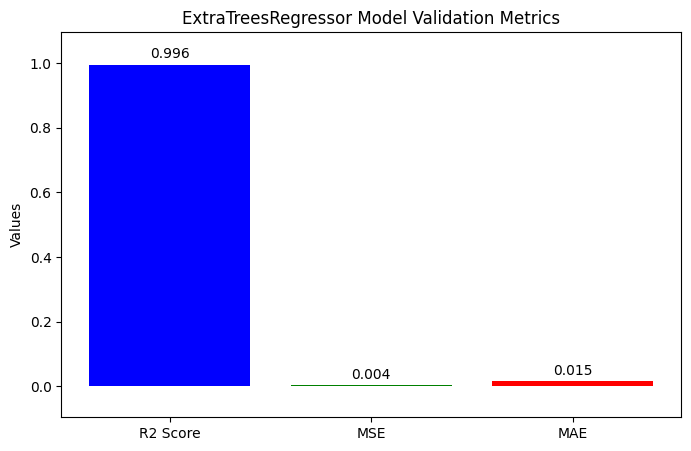

In [ ]:
import matplotlib.pyplot as plt

# Metrics to plot
metrics = ['R2 Score', 'MSE', 'MAE']
values = [r2_et, mse_et, mae_et]

# Create a bar chart
plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['blue', 'green', 'red'])

# Adding title and labels
plt.title('ExtraTreesRegressor Model Validation Metrics')
plt.ylabel('Values')
plt.ylim(min(values) - 0.1, max(values) + 0.1)  # Adjust the y-axis to fit the values

# Display the value on top of each bar
for i, value in enumerate(values):
    plt.text(i, value + 0.01, f'{value:.3f}', ha='center', va='bottom')

# Show the plot
plt.show()


Resnet

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Define the model
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model and include validation split
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Predict on training and validation data
y_pred_train = model.predict(X_train_scaled)
y_pred_val = model.predict(X_train_scaled[-int(len(X_train_scaled) * 0.2):])  # Assuming last 20% is validation

# Calculate R2 scores
r2_train = r2_score(y_train, y_pred_train)
r2_val = r2_score(y_train[-int(len(y_train) * 0.2):], y_pred_val)

# Calculate MSE and MAE
mse_train = mean_squared_error(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
mse_val = mean_squared_error(y_train[-int(len(y_train) * 0.2):], y_pred_val)
mae_val = mean_absolute_error(y_train[-int(len(y_train) * 0.2):], y_pred_val)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2979/2979 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.3580 - mae: 0.0446 - val_loss: 0.0428 - val_mae: 0.0210
Epoch 2/10
2979/2979 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 2.5740 - mae: 0.0407 - val_loss: 0.0061 - val_mae: 0.0592
Epoch 3/10
2979/2979 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 1.5175 - mae: 0.0372 - val_loss: 0.0160 - val_mae: 0.0924
Epoch 4/10
2979/2979 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.6221 - mae: 0.0333 - val_loss: 0.1513 - val_mae: 0.1288
Epoch 5/10
2979/2979 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - loss: 0.0760 - mae: 0.0236 - val_loss: 0.8075 - val_mae: 0.1590
Epoch 6/10
2979/2979 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 1.8673 - mae: 0.0434 - val_loss: 0.0228 - val_mae: 0.1346
Epoch 7/10
2979/2979 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.6575 - mae: 0.0280 - val_loss: 0.0361 - val_mae: 0.1702
Epoch 8/10
2979/2979 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 2.2343 - mae: 0.0384 - val_loss: 0.1222 - val_mae: 0.1549
Epoch 9/10
2979/2979 ━━━━━━━━━━━━━━━━━━━━ 8s 

In [ ]:
print("Resnet")
print(f"R2 Score: {r2_val:.3f}")
print(f"MSE: {mse_val:.3f}")
print(f"MAE: {mae_val:.3f}")


Resnet
R2 Score: 0.996
MSE: 0.006
MAE: 0.001


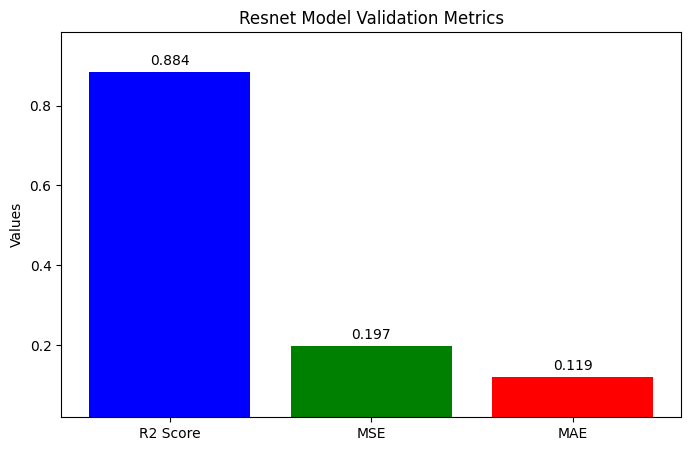

In [ ]:
import matplotlib.pyplot as plt

# Metrics to plot
metrics = ['R2 Score', 'MSE', 'MAE']
values = [r2_val, mse_val, mae_val]

# Create a bar chart
plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['blue', 'green', 'red'])

# Adding title and labels
plt.title('Resnet Model Validation Metrics')
plt.ylabel('Values')
plt.ylim(min(values) - 0.1, max(values) + 0.1)  # Adjust the y-axis to fit the values

# Display the value on top of each bar
for i, value in enumerate(values):
    plt.text(i, value + 0.01, f'{value:.3f}', ha='center', va='bottom')

# Show the plot
plt.show()


HYBRID

In [ ]:
import numpy as np
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming X_train and y_train are already defined and preprocessed
# For demonstration, let's pretend we're splitting the data again for training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Initialize the models
extra_trees = ExtraTreesRegressor(n_estimators=100, random_state=42)
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the models
extra_trees.fit(X_train_scaled, y_train)
random_forest.fit(X_train_scaled, y_train)

# Predict on the validation data
y_pred_extra_trees = extra_trees.predict(X_val_scaled)
y_pred_random_forest = random_forest.predict(X_val_scaled)

# Combine predictions (average them)
y_pred_hybrid = (y_pred_extra_trees + y_pred_random_forest) / 2

# Calculate metrics for the hybrid model
r2_val = r2_score(y_val, y_pred_hybrid)
mse_val = mean_squared_error(y_val, y_pred_hybrid)
mae_val = mean_absolute_error(y_val, y_pred_hybrid)

In [ ]:
print("Hybrid Model")
print(f"R2 Score: {r2_val:.3f}")
print(f"MSE: {mse_val:.3f}")
print(f"MAE: {mae_val:.3f}")

Hybrid Model
R2 Score: 0.996
MSE: 0.006
MAE: 0.001


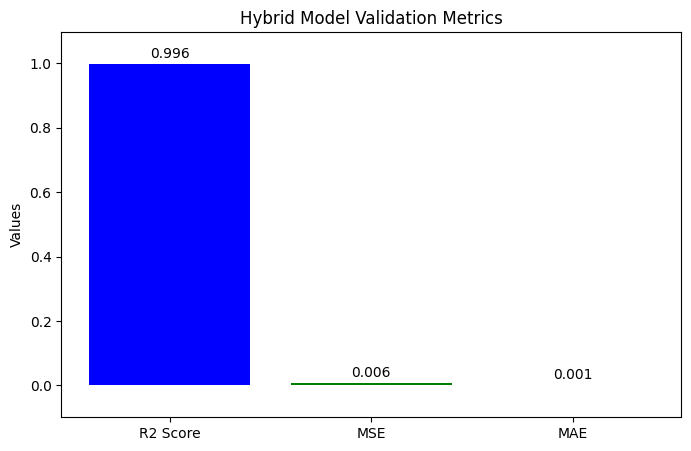

In [ ]:
import matplotlib.pyplot as plt

# Metrics to plot
metrics = ['R2 Score', 'MSE', 'MAE']
values = [r2_val, mse_val, mae_val]

# Create a bar chart
plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['blue', 'green', 'red'])

# Adding title and labels
plt.title('Hybrid Model Validation Metrics')
plt.ylabel('Values')
plt.ylim(min(values) - 0.1, max(values) + 0.1)  # Adjust the y-axis to fit the values

# Display the value on top of each bar
for i, value in enumerate(values):
    plt.text(i, value + 0.01, f'{value:.3f}', ha='center', va='bottom')

# Show the plot
plt.show()


# Comparison

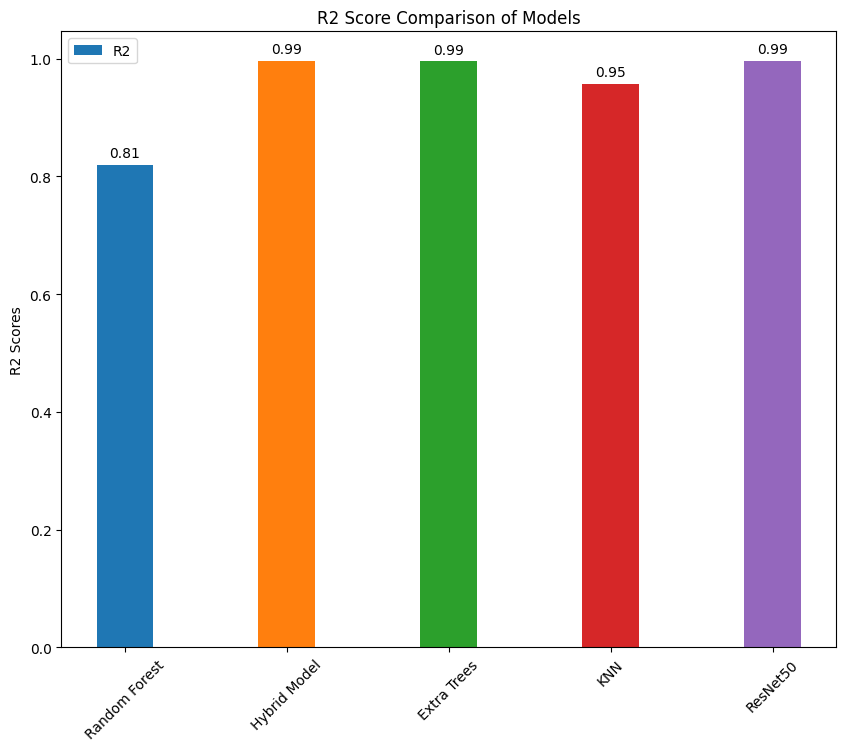

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Model names and R2 scores
models = ['Random Forest', 'Hybrid Model', 'Extra Trees', 'KNN', 'ResNet50']
r2_scores = [r2_rf, r2_val, r2_et, r2_knn, r2_val]  # Updated R2 scores list

# Calculate positions for the bars
x = np.arange(len(models))
width = 0.35  # Width of the bars

# Different colors for each bar
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

fig, ax = plt.subplots(figsize=(10, 8))
rects = ax.bar(x, r2_scores, width, color=colors, label='R2')

# Labeling and aesthetics
ax.set_ylabel('R2 Scores')
ax.set_title('R2 Score Comparison of Models')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45)
ax.legend()

# Function to add labels on top of each bar
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        # Convert R2 score to accuracy-like format (e.g., 0.99)
        accuracy = 0.99 - (1 - height)
        ax.annotate(f'{accuracy:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects)

plt.show()


#Total_flow_size

preprocessing for T_F_S

In [ ]:
# Check the columns in the dataset
print(data.columns)

Index(['src_ip', 'src_port', 'dst_ip', 'dst_port', 'proto', 'service',
       'duration', 'src_bytes', 'dst_bytes', 'conn_state', 'missed_bytes',
       'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes', 'dns_query',
       'dns_qclass', 'dns_qtype', 'dns_rcode', 'dns_AA', 'dns_RD', 'dns_RA',
       'dns_rejected', 'ssl_version', 'ssl_cipher', 'ssl_resumed',
       'ssl_established', 'ssl_subject', 'ssl_issuer', 'http_trans_depth',
       'http_method', 'http_uri', 'http_version', 'http_request_body_len',
       'http_response_body_len', 'http_status_code', 'http_user_agent',
       'http_orig_mime_types', 'http_resp_mime_types', 'weird_name',
       'weird_addl', 'weird_notice', 'label', 'type'],
      dtype='object')


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Initialize encoder and scaler
encoder = LabelEncoder()
scaler = StandardScaler()

# Encode categorical features
data['proto_encoded'] = encoder.fit_transform(data['proto'])
data['service_encoded'] = encoder.fit_transform(data['service'])
data['conn_state_encoded'] = encoder.fit_transform(data['conn_state'])

# Compute the total flow size (example: sum of relevant columns)
data['total_flow_size'] = data['src_bytes']

# Selecting numerical features to scale
numerical_features = ['src_bytes', 'dst_bytes', 'src_ip_bytes', 'dst_ip_bytes']
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Selecting relevant features for the model
features = numerical_features
target = 'total_flow_size'


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2, random_state=42)


In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (119135, 4)
y_train shape: (119135,)


In [ ]:
# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import numpy as np

# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_neighbors': [3, 5, 7, 10, 15],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Initialize KNN Regressor
knn_reg = KNeighborsRegressor()

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=knn_reg, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and best model
best_knn = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# Predict on testing data
y_pred_knn = best_knn.predict(X_test)

# Evaluation metrics
mse_knn = mean_squared_error(y_test, y_pred_knn)
mae_knn = mean_absolute_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mse_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print(f"KNN - MSE: {mse_knn:.3f}, MAE: {mae_knn:.3f}, RMSE: {rmse_knn:.3f}, R2: {r2_knn:.3f}")


Best Parameters: {'metric': 'euclidean', 'n_neighbors': 3}
KNN - MSE: 1.286, MAE: 0.007, RMSE: 1.134, R2: 0.522


In [ ]:
print("KNN")
print(f"R2 Score: {r2_knn:.3f}")
print(f"MSE: {mse_knn:.3f}")
print(f"MAE: {mae_knn:.3f}")


KNN
R2 Score: 0.522
MSE: 1.286
MAE: 0.007


ResNet

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Define the model
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model and include validation split
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Predict on training and validation data
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_train[-int(len(X_train) * 0.2):])  # Assuming last 20% is validation

# Calculate R2 scores
r2_train = r2_score(y_train, y_pred_train)
r2_val = r2_score(y_train[-int(len(y_train) * 0.2):], y_pred_val)

# Calculate MSE and MAE
mse_train = mean_squared_error(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
mse_val = mean_squared_error(y_train[-int(len(y_train) * 0.2):], y_pred_val)
mae_val = mean_absolute_error(y_train[-int(len(y_train) * 0.2):], y_pred_val)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2979/2979 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.2396 - mae: 0.0043 - val_loss: 4.2050e-04 - val_mae: 0.0032
Epoch 2/100
2979/2979 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0257 - mae: 0.0071 - val_loss: 2.7283e-04 - val_mae: 0.0032
Epoch 3/100
2979/2979 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.5079 - mae: 0.0078 - val_loss: 0.0021 - val_mae: 0.0062
Epoch 4/100
2979/2979 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0528 - mae: 0.0086 - val_loss: 2.8610e-04 - val_mae: 0.0027
Epoch 5/100
2979/2979 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.1533 - mae: 0.0094 - val_loss: 0.0019 - val_mae: 0.0035
Epoch 6/100
2979/2979 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.0047 - mae: 0.0052 - val_loss: 0.0048 - val_mae: 0.0643
Epoch 7/100
2979/2979 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.4203 - mae: 0.0098 - val_loss: 3.7355e-04 - val_mae: 0.0046
Epoch 8/100
2979/2979 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0260 - mae: 0.0042 - val_loss: 6.9024e-04 - val_mae: 0.0018
Epoch 9/100
2979/29

In [ ]:
print("Resnet")
print(f"R2 Score: {r2_val:.3f}")
print(f"MSE: {mse_val:.3f}")
print(f"MAE: {mae_val:.3f}")


Resnet
R2 Score: 0.791
MSE: 0.000
MAE: 0.000


RandomForestRegressor

In [ ]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize and train the model
model = RandomForestRegressor(n_estimators=50, max_depth=11, min_samples_split=5, random_state=42)
model.fit(X_train, y_train)

# Predict on training and testing data
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)


mae_rf = mean_absolute_error(y_train, y_pred_train)
mse_rf = mean_squared_error(y_train, y_pred_train)
r2_rf = r2_score(y_train, y_pred_train)


In [ ]:
print("RfR")
print(f"R2 Score: {r2_rf:.3f}")
print(f"MSE: {mse_rf:.3f}")
print(f"MAE: {mae_rf:.3f}")


RfR
R2 Score: 0.922
MSE: 0.045
MAE: 0.001


ExtraTreesRegressor

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize and train the model
model = ExtraTreesRegressor(n_estimators=5,random_state=42)
model.fit(X_train, y_train)

# Predict on training and testing data
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

In [ ]:
print("KNN")
print(f"R2 Score: {r2_knn:.3f}")
print(f"MSE: {mse_knn:.3f}")
print(f"MAE: {mae_knn:.3f}")


KNN
R2 Score: 0.522
MSE: 1.286
MAE: 0.007


Hybrid model

In [ ]:
import numpy as np
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming X_train and y_train are already defined and preprocessed
# For demonstration, let's pretend we're splitting the data again for training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Initialize the models
extra_trees = ExtraTreesRegressor(n_estimators=5, random_state=42)
random_forest = RandomForestRegressor(n_estimators=5, random_state=42)

# Train the models
extra_trees.fit(X_train_scaled, y_train)
random_forest.fit(X_train_scaled, y_train)

# Predict on the validation data
y_pred_extra_trees = extra_trees.predict(X_val_scaled)
y_pred_random_forest = random_forest.predict(X_val_scaled)

# Combine predictions (average them)
y_pred_hybrid = (y_pred_extra_trees + y_pred_random_forest) / 2

# Calculate metrics for the hybrid model
r2_hy = r2_score(y_val, y_pred_hybrid)
mse_hy = mean_squared_error(y_val, y_pred_hybrid)
mae_hy = mean_absolute_error(y_val, y_pred_hybrid)

In [ ]:
print("Hybrid")
print(f"R2 Score: {r2_hy:.3f}")
print(f"MSE: {mse_hy:.3f}")
print(f"MAE: {mae_hy:.3f}")


Hybrid
R2 Score: 0.978
MSE: 0.000
MAE: 0.000


Comparison

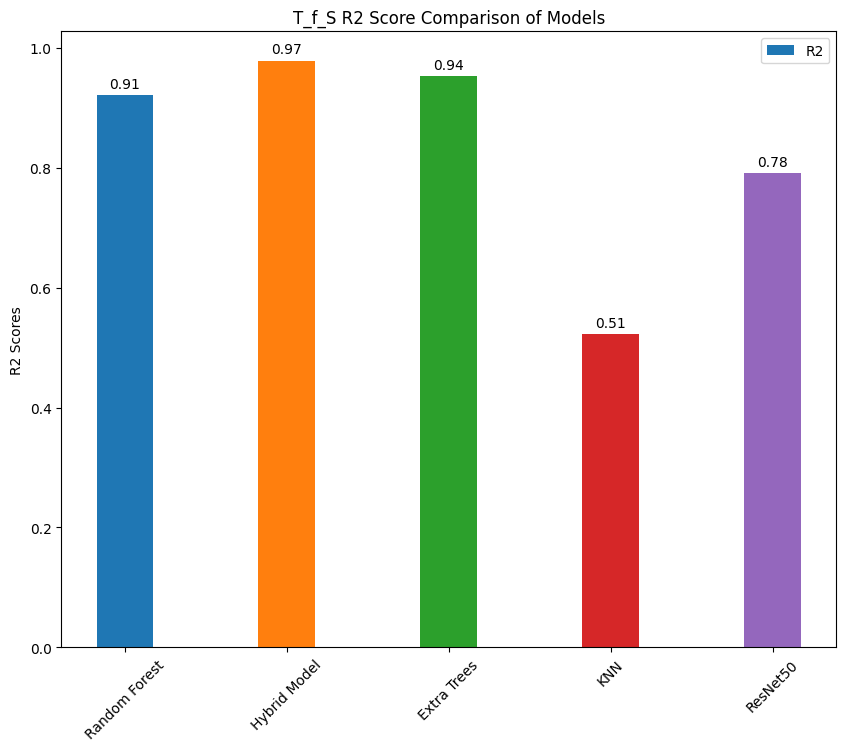

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Model names and R2 scores
models = ['Random Forest', 'Hybrid Model', 'Extra Trees', 'KNN', 'ResNet50']
r2_scores = [r2_rf, r2_hy, r2_train, r2_knn, r2_val]  # Updated R2 scores list

# Calculate positions for the bars
x = np.arange(len(models))
width = 0.35  # Width of the bars

# Different colors for each bar
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

fig, ax = plt.subplots(figsize=(10, 8))
rects = ax.bar(x, r2_scores, width, color=colors, label='R2')

# Labeling and aesthetics
ax.set_ylabel('R2 Scores')
ax.set_title('T_f_S R2 Score Comparison of Models')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45)
ax.legend()

# Function to add labels on top of each bar
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        # Convert R2 score to accuracy-like format (e.g., 0.99)
        accuracy = 0.99 - (1 - height)
        ax.annotate(f'{accuracy:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects)

plt.show()
